# Proprocessing data

In [1]:
import app
from lib.factor_analysis import plot_correlogram, plot_returns_corr, test_ljung_box, adf_test, find_volitile_month

df1 , df_hist_ret, df_vol =app.preprocess_data()

2024-11-07 14:29:33.321 | INFO     | app:preprocess_data:15 - Starting to preprocess data
2024-11-07 14:29:33.322 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^TNX
2024-11-07 14:29:33.325 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - SQ
2024-11-07 14:29:33.327 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^VIX
2024-11-07 14:29:33.328 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^XAU
2024-11-07 14:29:33.330 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^IRX
2024-11-07 14:29:33.331 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - RIOT
2024-11-07 14:29:33.333 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^TYX
2024-11-07 14:29:33.335 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - NVDA
2024-11-07 14:29:33.337 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^FVX
2024-11-07 14:29:33.339 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - SPY
2024-11-07 14:29:33.341

# Construct Cross Market Factor (Crypto + SPX 500)


<Axes: >

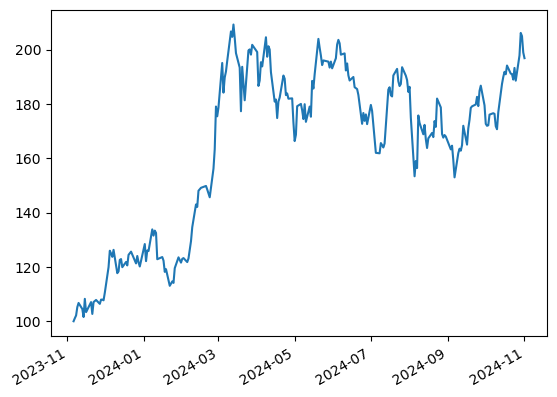

In [2]:
s_crypto_market, s_big_market = app.construct_market_factors(df1)
s_crypto_market.plot()

# Ljung-Box Test
Ljung-Box is a test for autocorrelation that we can use in tandem with our ACF and PACF plots. The Ljung-Box test takes our data, optionally either lag values to test, or the largest lag value to consider, and whether to compute the Box-Pierce statistic. Ljung-Box and Box-Pierce are two similar test statisitcs,  Q
 , that are compared against a chi-squared distribution to determine if the series is white noise. We might use the Ljung-Box test on the residuals of our model to look for autocorrelation, ideally our residuals would be white noise.

- Ho : The data are independently distributed, no autocorrelation.
- Ha : The data are not independently distributed; they exhibit serial correlation.

The Ljung-Box with the Box-Pierce option will return, for each lag, the Ljung-Box test statistic, Ljung-Box p-values, Box-Pierce test statistic, and Box-Pierce p-values.

If  p<α (0.05) we reject the null hypothesis.

## The following code should show that lag 34 and 35 in the return series have some autocorrelation

In [3]:

ret_big_market=s_big_market.pct_change().dropna()
test_ljung_box(returns =ret_big_market)


      lb_stat  lb_pvalue    bp_stat  bp_pvalue
34  54.516634   0.014253  49.850515   0.038918
35  54.541875   0.018744  49.872035   0.049319


## ADF test shows the series is stationary

In [4]:

adf_test(ret_big_market)

The series is stationary, with p-value from ADF 8.738189746924967e-30


# Observe Volatility Clustering

- Volatility clustering refers to the observation that "large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes.
- Ljung-Box test on the squared returns finds significant autocorrelation at multiple lags, this is indicative of volatility clustering.

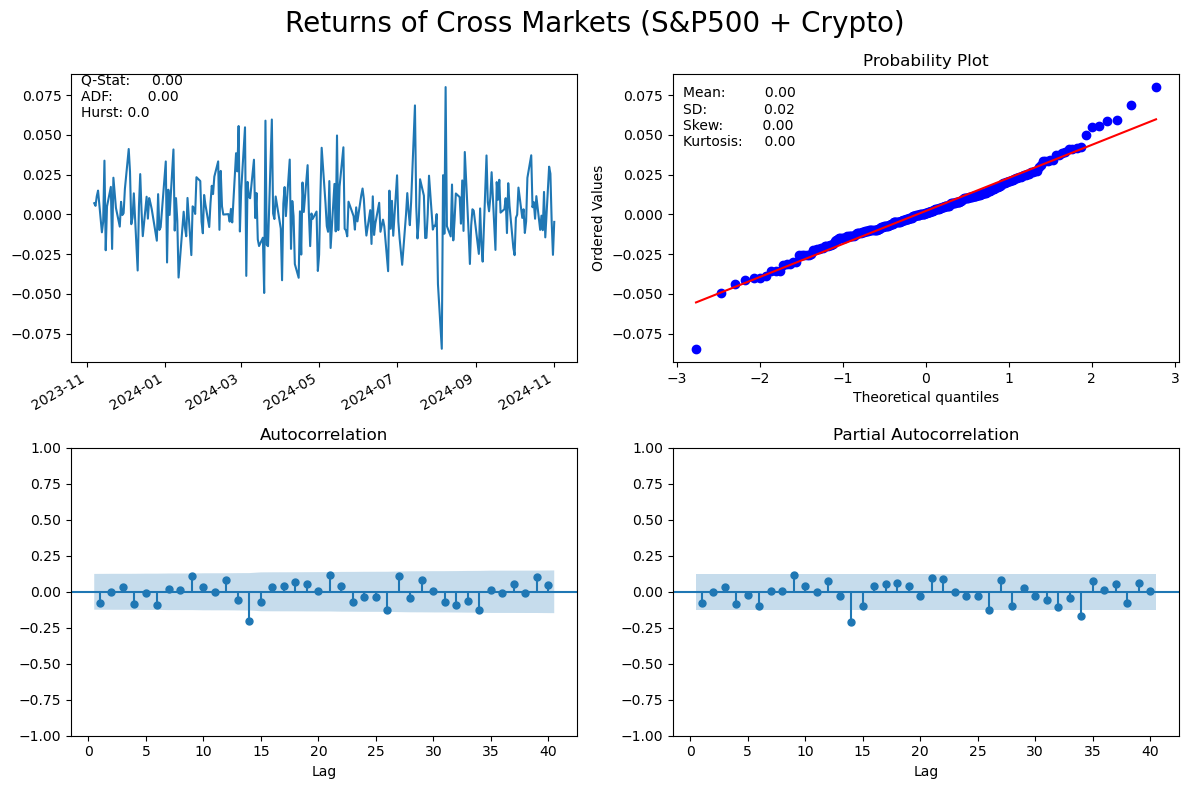

In [5]:
plot_correlogram(ret_big_market, lags=40, title="Returns of Cross Markets (S&P500 + Crypto)")

# Squared returns series exhibits auto correlation

In [6]:
import numpy as np
vol = np.log(s_big_market).diff().dropna()
variance = vol * vol
test_ljung_box(variance)

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
3   18.657996   0.000322  18.299685   0.000381
4   19.789976   0.000549  19.404606   0.000654
5   20.136810   0.001178  19.741766   0.001397
6   20.786705   0.002004  20.370948   0.002378
7   22.175032   0.002370  21.709494   0.002850
8   22.524547   0.004031  22.045084   0.004833
9   22.618503   0.007112  22.134923   0.008461
10  23.084215   0.010440  22.578369   0.012415
11  23.656297   0.014263  23.120822   0.016994
12  23.656388   0.022643  23.120908   0.026717
13  23.749811   0.033511  23.208748   0.039238
14  30.032018   0.007555  29.090495   0.010160
15  40.161232   0.000429  38.533667   0.000752
16  40.180188   0.000733  38.551264   0.001262
17  40.320523   0.001166  38.680976   0.001979
18  41.739911   0.001202  39.987265   0.002096
19  42.510841   0.001511  40.693695   0.002651
20  42.738789   0.002213  40.901663   0.003835
21  43.211043   0.002954  41.330643   0.005102
22  44.130175   0.003416  42.161890   0.005975
23  44.136665

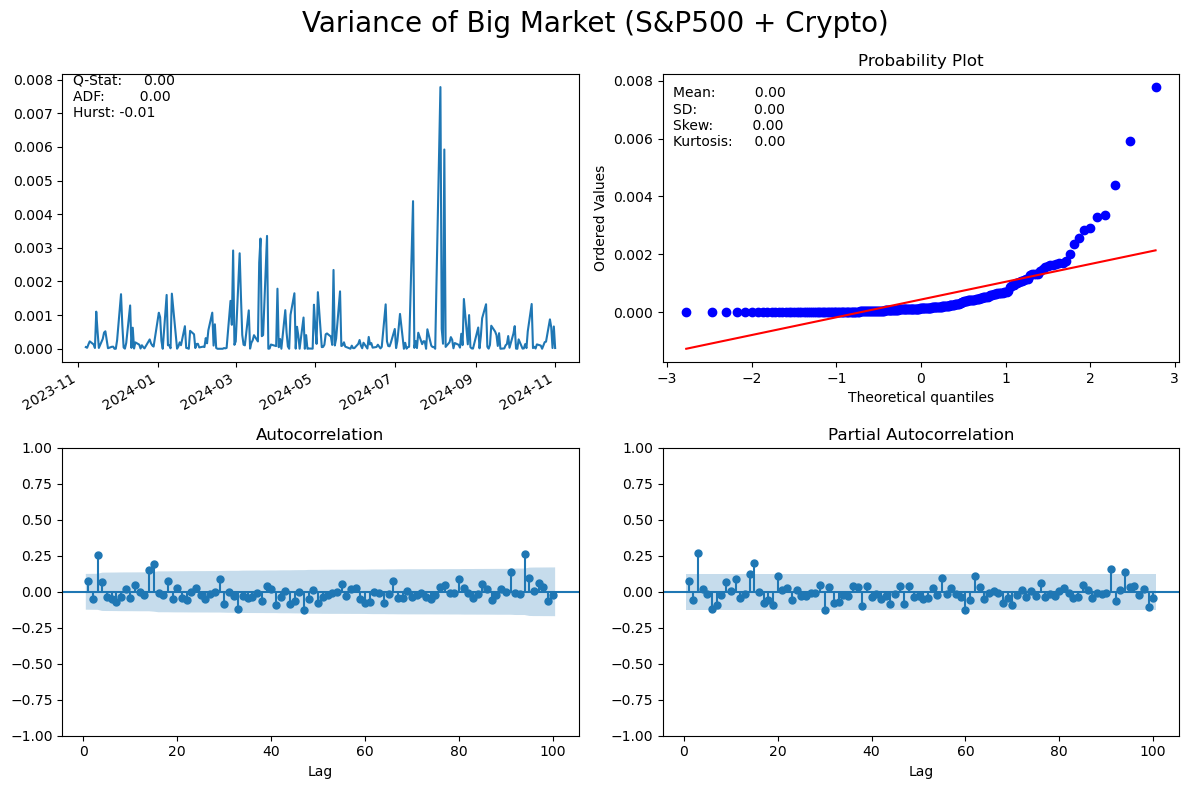

In [7]:
plot_correlogram(variance, lags=100, title='Variance of Big Market (S&P500 + Crypto)')

# Run GARCH and big market returns and identify the high volatility period
- Calculate  𝛼 + 𝛽 = 0.1210 + 0.5954 = 0.7164 .This value is less than 1, which indicates that the model captures some persistence in volatility. However, it suggests that shocks to volatility will eventually dissipate over time, rather than persisting indefinitely.
- The coefficient  β=0.5954 is statistically significant (p-value = 0.0002674), suggesting that past volatility influences current volatility.
- The coefficient α=0.1210 is not statistically significant (p-value = 0.222), which means that the contribution of past squared returns is not strong. This could imply that while there is some volatility clustering, it may not be as pronounced as in cases where both coefficients are significant.

In [8]:
from arch import arch_model

In [9]:
market_returns = s_big_market.pct_change().dropna()
model = arch_model(market_returns, vol="Garch", p=1, q=1)
res = model.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: -610.3242286881391
Optimization terminated successfully    (Exit mode 0)
            Current function value: -614.2732728022149
            Iterations: 7
            Function evaluations: 52
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                614.273
Distribution:                  Normal   AIC:                          -1220.55
Method:            Maximum Likelihood   BIC:                          -1206.48
                                        No. Observations:                  249
Date:                Thu, Nov 07 2024   Df Residuals:                      248
Time:                        14:29:37   Df Model:                            1
        

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000435. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


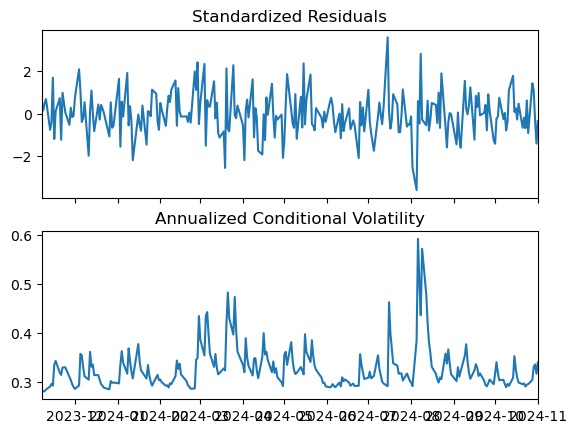

In [10]:
fig = res.plot(annualize="D")

# Identify High Volatile Period using GARCH conditional volatility.
Both eyeball test plus GARCH model using 75% quantile high volatility threshold show that March and August are most volatile

In [11]:
df_mkt, r = find_volitile_month(market_returns, res.conditional_volatility,  state="high vol")

In [12]:
df_mkt['market_condition'].unique()

array(['Neutral', 'Bull Market - High Volatility',
       'Bull Market - Low Volatility', 'Bear Market - Low Volatility',
       'Bear Market - High Volatility'], dtype=object)

<Axes: >

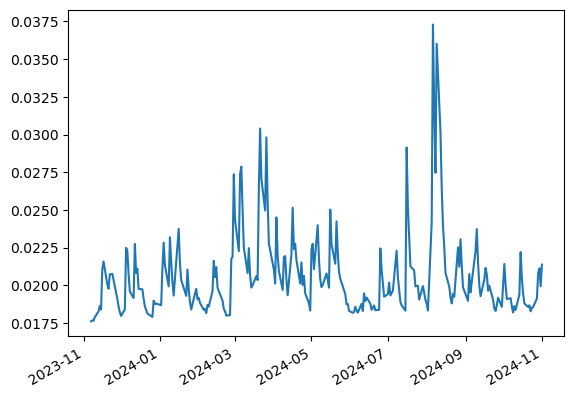

In [13]:
df_mkt['conditional_volatility'].plot()

In [14]:
r.sort_values()

0
2024-06-30     1
2024-10-31     1
2024-09-30     2
2023-12-31     3
2024-01-31     4
2024-02-29     4
2024-07-31     4
2024-05-31     8
2024-04-30     9
2024-08-31    11
2024-03-31    14
Name: count, dtype: int64

# Identify Low Volatile Period using GARCH conditional volatility.
GARCH conditional volaitlity with 25% quantile threshold shows that June is not volatile

In [15]:
df_mkt, r = find_volitile_month(market_returns, res.conditional_volatility,  state="low vol")

In [16]:
r.sort_values()

0
2024-03-31    0
2024-05-31    0
2024-01-31    1
2024-02-29    1
2024-04-30    1
2024-07-31    1
2024-06-30    4
Name: count, dtype: int64

# Use K-Means to identify volatility clustering

<Axes: >

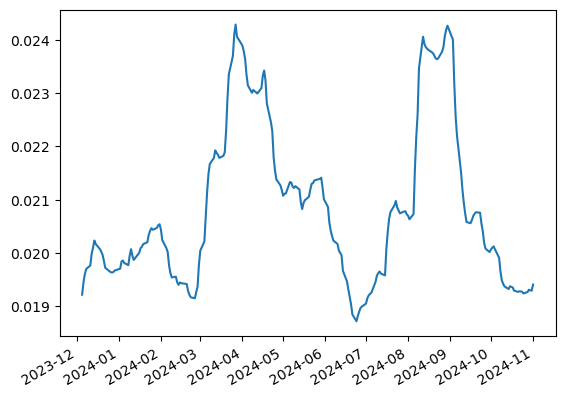

In [24]:
window_size = 20  # Example: 20-day window

smoothed_garch_vol=df_mkt['conditional_volatility'].rolling(window=window_size).mean()
smoothed_garch_vol.plot()

In [25]:
df_mkt['smoothed_garch_vol']=smoothed_garch_vol

df_cluster=df_mkt[['market_returns','smoothed_garch_vol']].dropna()

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

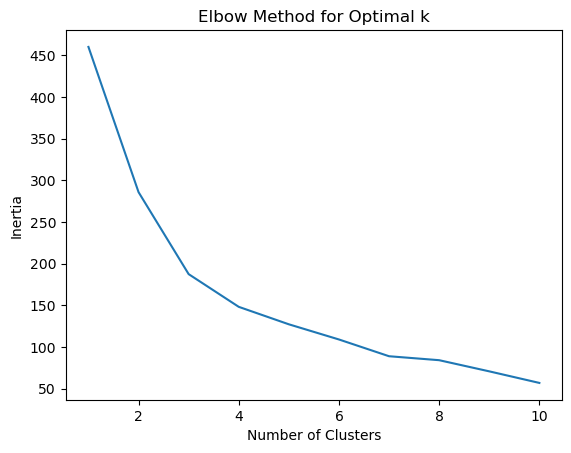

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [28]:
optimal_k = 4 # Replace with your chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(scaled_data)

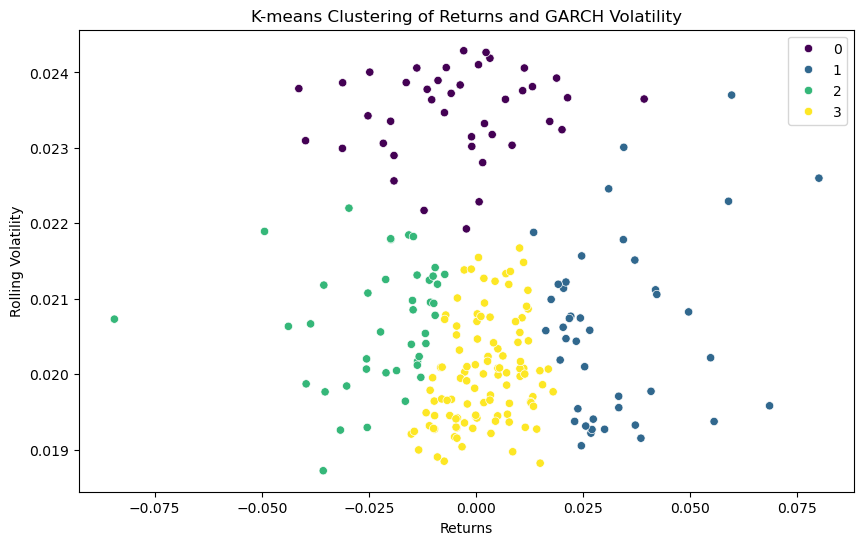

In [29]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='market_returns', y='smoothed_garch_vol', hue='Cluster', data=df_cluster, palette='viridis')
plt.title('K-means Clustering of Returns and GARCH Volatility')
plt.xlabel('Returns')
plt.ylabel('Rolling Volatility')
plt.legend()
plt.show()

# High Volatlity is state 0 here, 
- mainly in March, April and August
- consistent with eye ball test using GARCH conditional volatility chart


In [30]:
df_cluster[df_cluster['Cluster']==0].index

DatetimeIndex(['2024-03-12', '2024-03-21', '2024-03-22', '2024-03-26',
               '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02',
               '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-09',
               '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
               '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19',
               '2024-04-23', '2024-08-07', '2024-08-09', '2024-08-12',
               '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
               '2024-08-19', '2024-08-20', '2024-08-21', '2024-08-22',
               '2024-08-23', '2024-08-26', '2024-08-27', '2024-08-28',
               '2024-08-29', '2024-08-30', '2024-09-03', '2024-09-04',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)

# Correlation of different assets across the past 1 year


<Axes: >

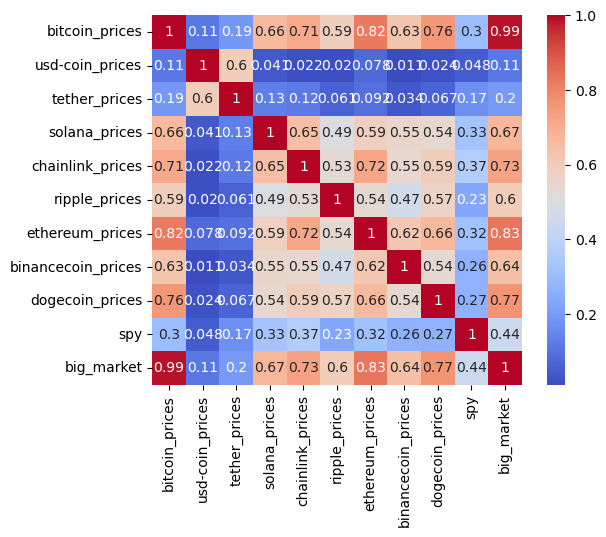

In [24]:

import seaborn as sns
df_rets =plot_returns_corr(df1,s_big_market)
corr=df_rets.corr()
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)

heatmap

In [25]:

rolling_corr = df_rets.rolling(window=30).corr()


# 30Day Rolling Correlation as of 2024-03-28

<Axes: >

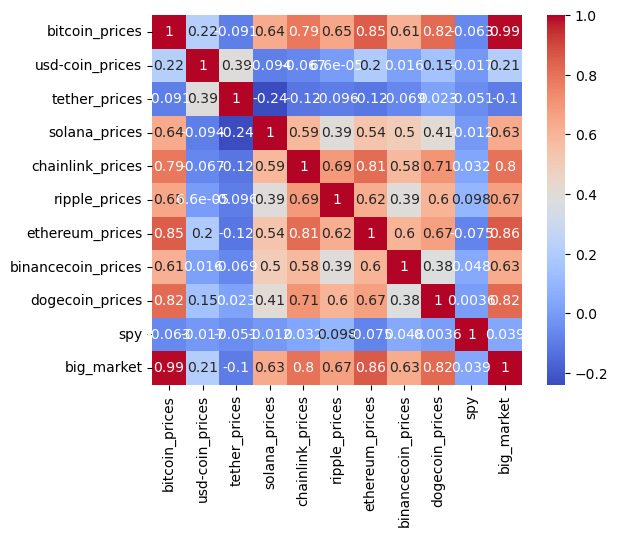

In [38]:

heatmap = sns.heatmap(rolling_corr.loc['2024-03-28'], annot=True, cmap='coolwarm', square=True)

heatmap

# 30Day Rolling Correlation as of 2024-08-30

<Axes: >

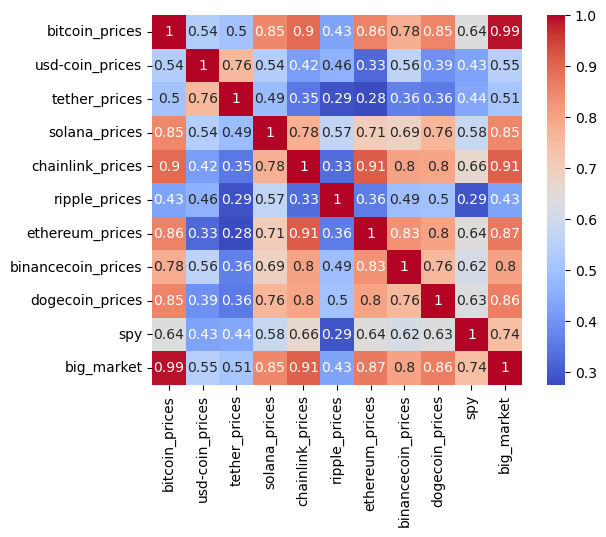

In [39]:

heatmap = sns.heatmap(rolling_corr.loc['2024-08-30'], annot=True, cmap='coolwarm', square=True)

heatmap

## Compare with low volatile period (June) correlation

<Axes: >

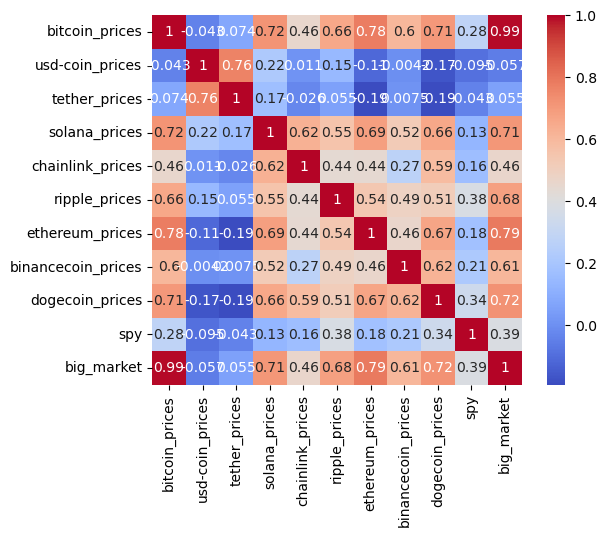

In [40]:

heatmap = sns.heatmap(rolling_corr.loc['2024-06-28'], annot=True, cmap='coolwarm', square=True)

heatmap

# Appendix1: How to Analyze Output of GARCH Model on SPY Returns (all the credit goes to Poe.com)



Analyzing the output of a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model applied to SPY (S&P 500 ETF) returns involves several steps. Here's a structured approach:

#### 1. Understanding GARCH Output Components

A GARCH model typically provides several key outputs:

- **Coefficient Estimates:** These represent the relationship between past returns and volatility.
- **Standard Errors:** Indicate the precision of the coefficient estimates.
- **t-Statistics and P-Values:** Help assess the statistical significance of each coefficient.
- **Log-Likelihood:** Used to compare the goodness of fit of different models.
- **Conditional Volatility Estimates:** The model's estimate of volatility at each point in time.

#### 2. Key Outputs to Analyze

- **Mean Equation:** Look at coefficients related to the return series. Are they significant? What is their sign?
- **Variance Equation:** Focus on the parameters (like alpha and beta) that indicate how past shocks and past variances affect current volatility.
  - **Alpha (α):** Measures the impact of past squared returns (news) on current volatility.
  - **Beta (β):** Measures the impact of past volatility on current volatility.
- **Persistence:** The sum of α and β indicates how persistent the volatility is. A sum close to 1 suggests long-lasting effects of shocks.

#### 3. Check for Model Adequacy

- **Residual Analysis:** Examine the residuals (the difference between observed and fitted values) for patterns. They should resemble white noise.
- **Ljung-Box Test:** Conduct this test on the residuals to check for autocorrelation.
- **ARCH Test:** Test for remaining ARCH effects in the residuals. A significant result suggests the model may not be adequate.

#### 4. Volatility Forecasting

- **Conditional Volatility:** Analyze the estimated conditional volatility over time. Is it stable, or does it exhibit clustering (periods of high volatility followed by low volatility)?
- **Forecasting:** Use the model to generate volatility forecasts and compare them with actual realized volatility.

#### 5. Economic Interpretation

- **Market Implications:** High volatility estimates could indicate market uncertainty or risk. Consider how these estimates align with market events during the sample period.
- **Investment Decisions:** Use the insights from the GARCH model to inform risk management strategies or trading decisions.

#### 6. Visualization

- **Plotting Conditional Volatility:** Visualize the estimated conditional volatility over time against the SPY returns to assess how well the model captures volatility spikes.
- **Historical Volatility Comparison:** Compare GARCH forecasts to historical realized volatility measures to evaluate model performance.

#### 7. Further Steps

- **Model Comparison:** If necessary, compare multiple GARCH models (like EGARCH or GJR-GARCH) to find the best fit.
- **Robustness Checks:** Consider using different time windows or sub-samples to ensure the model's findings are robust.

### Conclusion

Analyzing the output of a GARCH model on SPY returns provides valuable insights into the volatility dynamics of the ETF. By carefully examining the model's components and conducting thorough diagnostics, you can derive meaningful interpretations that can aid in investment decisions and risk management.